In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_path ='/content/drive/MyDrive/PolypDB.zip'

# Unzipping the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/polyp_dataset')

# Check if the dataset is unzipped successfully
extracted_path = '/content/polyp_dataset/'
print(os.listdir(extracted_path))

['PolypDB', '__MACOSX']


Found 70 image-mask pairs.
Training set: (56, 256, 256, 3), (56, 256, 256, 1)
Validation set: (7, 256, 256, 3), (7, 256, 256, 1)
Test set: (7, 256, 256, 3), (7, 256, 256, 1)


/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/BLI_augmented_mask/augmented_mask_0.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/BLI_augmented_mask/augmented_mask_1.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/BLI_augmented_mask/augmented_mask_2.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/BLI_augmented_mask/augmented_mask_3.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:328: UserWarning: /content/BLI_augmented_mask/augmented_mask_4.png is a low contrast image
  return func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/skimage/_shared/utils.py:

Final Training set: (556, 256, 256, 3), (556, 256, 256, 1)


<ipython-input-33-bfd63744efc3>:126: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(aug_x_train[0])
<ipython-input-33-bfd63744efc3>:129: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  imshow(aug_y_train[0, :, :, 0], cmap='gray')
/usr/local/lib/python3.11/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


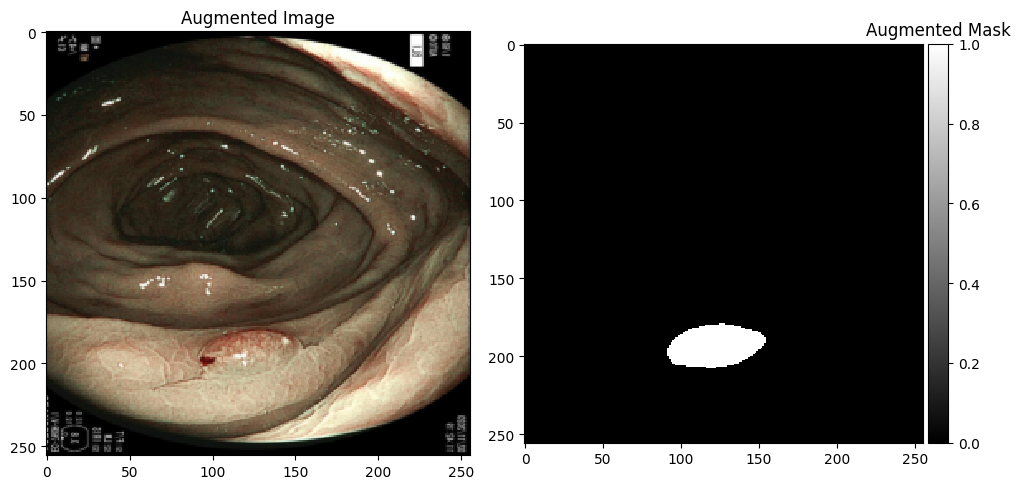

In [ ]:
import os
import numpy as np
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as A
import random

# Define dataset paths
image_dir = '/content/polyp_dataset/PolypDB/PolypDB_modality_wise/BLI/images'
mask_dir = '/content/polyp_dataset/PolypDB/PolypDB_modality_wise/BLI/masks'

# Image parameters
IMG_HEIGHT, IMG_WIDTH = 256, 256
CHANNELS = 3
TARGET_SIZE = 500  # Augmented dataset size

# Get sorted file lists
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

# Check image-mask consistency
if len(image_files) != len(mask_files):
    print(f"Warning: Image-mask count mismatch. Images: {len(image_files)}, Masks: {len(mask_files)}")
else:
    print(f"Found {len(image_files)} image-mask pairs.")

def load_and_preprocess(index):
    """Load, resize, and preprocess an image-mask pair."""
    image_path = os.path.join(image_dir, image_files[index])
    mask_path = os.path.join(mask_dir, mask_files[index])

    image = imread(image_path)
    mask = imread(mask_path, as_gray=True)

    # Ensure correct shape (for RGBA images)
    if image.shape[-1] == 4:
        image = image[:, :, :3]

    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='reflect', anti_aliasing=True)

    # Convert mask to binary
    mask = (mask > 0.5).astype(np.uint8)

    return (image * 255).astype(np.uint8), mask

# Augmentation Pipelines (Reduced p values for better variation)
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Transpose(p=0.5),
    A.GridDistortion(p=0.3),  # Lowered probability
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5)  # Added color augmentation
])

# Augmented dataset directories
img_augmented_path = "/content/Bli_augmented_image"
msk_augmented_path = "/content/BLI_augmented_mask"

# Create directories if they don't exist
os.makedirs(img_augmented_path, exist_ok=True)
os.makedirs(msk_augmented_path, exist_ok=True)

# Load and preprocess images
all_x = []
all_y = []

for count in range(len(image_files)):
    x, y = load_and_preprocess(count)
    all_x.append(x)
    all_y.append(y)

# Convert lists to numpy arrays
all_x = np.array(all_x)
all_y = np.expand_dims(np.array(all_y), axis=-1)  # Add an extra dimension for the mask

# Split dataset (80% train, 10% val, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(all_x, all_y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print(f"Training set: {x_train.shape}, {y_train.shape}")
print(f"Validation set: {x_val.shape}, {y_val.shape}")
print(f"Test set: {x_test.shape}, {y_test.shape}")

# Augment the training data (up to TARGET_SIZE)
aug_x_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype=np.uint8)
aug_y_train = np.zeros((TARGET_SIZE, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

for count in range(TARGET_SIZE):
    index = random.randint(0, len(x_train) - 1)
    image = x_train[index]
    mask = y_train[index, :, :, 0]

    # Augment the image and mask
    augmented = aug(image=image, mask=mask)
    aug_x_train[count] = augmented['image']
    aug_y_train[count, :, :, 0] = augmented['mask']

    # Optionally save augmented images and masks
    new_image_path = os.path.join(img_augmented_path, f"augmented_image_{count}.png")
    new_mask_path = os.path.join(msk_augmented_path, f"augmented_mask_{count}.png")

    imsave(new_image_path, aug_x_train[count])
    imsave(new_mask_path, aug_y_train[count, :, :, 0])
# Combine original and augmented data
final_x_train = np.concatenate((x_train, aug_x_train), axis=0)
final_y_train = np.concatenate((y_train, aug_y_train), axis=0)

# Print the new dataset size
print(f"Final Training set: {final_x_train.shape}, {final_y_train.shape}")

# Optionally shuffle the dataset
indices = np.arange(final_x_train.shape[0])
np.random.shuffle(indices)

final_x_train = final_x_train[indices]
final_y_train = final_y_train[indices]

# Display a sample image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(aug_x_train[0])
plt.title("Augmented Image")
plt.subplot(1, 2, 2)
imshow(aug_y_train[0, :, :, 0], cmap='gray')
plt.title("Augmented Mask")
plt.show()


In [ ]:
np.save("/content/final-x-train.npy", final_x_train)
np.save("/content/final-y-train.npy", final_y_train)

In [ ]:
import numpy as np

# Load the saved arrays
final_x_train = np.load("/content/final-x-train.npy")
final_y_train = np.load("/content/final-y-train.npy")

# Print the shapes
print("final_x_train shape:", final_x_train.shape)
print("final_y_train shape:", final_y_train.shape)

final_x_train shape: (556, 256, 256, 3)
final_y_train shape: (556, 256, 256, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Reshape, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

IMG_SIZE = 256  # Ensure the output matches this size

def se_block(input_tensor, ratio=16):
    """ Squeeze-and-Excitation Block """
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(channels // ratio, activation="relu")(se)
    se = Dense(channels, activation="sigmoid")(se)
    se = Reshape((1, 1, channels))(se)
    return Multiply()([input_tensor, se])

def drop_block(x, drop_prob=0.2, block_size=3):
    """ DropBlock Implementation """
    if drop_prob == 0.0:
        return x
    return Dropout(rate=drop_prob)(x)

def unet_efficientnetb4(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = tf.keras.applications.EfficientNetB4(
        include_top=False,
        weights="imagenet",
        input_shape=input_size
    )

    # Encoder Feature Maps
    s1 = base_model.get_layer("block2a_expand_activation").output  # (64x64, 32)
    s2 = base_model.get_layer("block3a_expand_activation").output  # (32x32, 56)
    s3 = base_model.get_layer("block4a_expand_activation").output  # (16x16, 112)
    s4 = base_model.get_layer("block6a_expand_activation").output  # (8x8, 272)
    b5 = base_model.get_layer("top_activation").output  # (4x4, 1792) Bottleneck

    # Decoder with SE blocks, DropBlock, Dilated Convolutions, and L2 Regularization
    u6 = UpSampling2D(size=(2, 2))(b5)
    u6 = Conv2D(272, (1, 1), padding="same", kernel_regularizer=l2(1e-4))(u6)
    u6 = concatenate([u6, s4])
    c6 = Conv2D(272, (3, 3), activation="relu", padding="same", dilation_rate=(2,2), kernel_regularizer=l2(1e-4))(u6)
    c6 = drop_block(c6)
    c6 = Conv2D(272, (3, 3), activation="relu", padding="same", dilation_rate=(2,2), kernel_regularizer=l2(1e-4))(c6)
    c6 = se_block(c6)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = Conv2D(112, (1, 1), padding="same", kernel_regularizer=l2(1e-4))(u7)
    u7 = concatenate([u7, s3])
    c7 = Conv2D(112, (3, 3), activation="relu", padding="same", dilation_rate=(2,2), kernel_regularizer=l2(1e-4))(u7)
    c7 = drop_block(c7)
    c7 = Conv2D(112, (3, 3), activation="relu", padding="same", dilation_rate=(2,2), kernel_regularizer=l2(1e-4))(c7)
    c7 = se_block(c7)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = Conv2D(56, (1, 1), padding="same", kernel_regularizer=l2(1e-4))(u8)
    u8 = concatenate([u8, s2])
    c8 = Conv2D(56, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(u8)
    c8 = drop_block(c8)
    c8 = Conv2D(56, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(c8)
    c8 = se_block(c8)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = Conv2D(32, (1, 1), padding="same", kernel_regularizer=l2(1e-4))(u9)
    u9 = concatenate([u9, s1])
    c9 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(u9)
    c9 = drop_block(c9)
    c9 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(c9)
    c9 = se_block(c9)

    u10 = UpSampling2D(size=(2, 2))(c9)
    c10 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(u10)
    c10 = drop_block(c10)
    c10 = Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(1e-4))(c10)

    # 🚀 Final layer should output (256, 256, 1)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c10)  # (256, 256, 1)

    return Model(inputs=base_model.input, outputs=outputs)

model = unet_efficientnetb4()
model.summary()


71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 256, 256, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 256, 256, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 257, 257, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 128, 128, 48)   │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 128, 128, 48)   │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 128, 128, 48)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 128, 128, 48)   │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 128, 128, 48)   │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 128, 128, 48)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 22,690,893 (86.56 MB)

 Trainable params: 22,565,686 (86.08 MB)

 Non-trainable params: 125,207 (489.09 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, concatenate, GlobalAveragePooling2D, Dense, Reshape, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


def tversky_loss(y_true, y_pred, alpha=0.6, beta=0.4, epsilon=1e-6):
    # Flatten the input tensors
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])

    # True Positives (TP), False Positives (FP), False Negatives (FN)
    TP = tf.reduce_sum(y_true * y_pred)
    FP = tf.reduce_sum((1 - y_true) * y_pred)
    FN = tf.reduce_sum(y_true * (1 - y_pred))

    # Calculate the Tversky Index
    tversky_index = (TP + epsilon) / (TP + alpha * FP + beta * FN + epsilon)

    # Tversky Loss is the complement of the Tversky Index
    return 1 - tversky_index




# Loss and Metric Functions
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + 1e-6)
    return 1 - iou

def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    loss = alpha * tf.pow(1 - y_pred, gamma) * bce
    return loss



In [ ]:
def combo_loss(y_true, y_pred, dice_weight=0.3, bce_weight=0.2,iou_weight=0.2,tversky_weight=0.3, pos_weight=6.0, neg_weight=1.0):
    y_true = tf.cast(y_true, tf.float32)

    # Dice Loss
    dice = dice_loss(y_true, y_pred)

    # Binary Cross-Entropy (Weighted)
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    weighted_bce = pos_weight * y_true * bce + neg_weight * (1 - y_true) * bce

    # IoU Loss
    iou = iou_loss(y_true, y_pred)

    # Tversky Loss (For Imbalance)
    tversky = tversky_loss(y_true, y_pred)

    # Compute final loss with weights
    return (dice_weight * dice +
            bce_weight * tf.reduce_mean(weighted_bce) + iou_weight * iou + tversky_weight * tversky
            )

In [ ]:

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


# Define Adam optimizer with an initial learning rate
initial_lr = 1e-4
optimizer = Adam(learning_rate=initial_lr)


def lr_schedule(epoch, lr):
    if epoch < 5:  # Warmup phase
        return lr * 1.5  # Increase LR to stabilize training
    elif epoch < 30:
        return lr * 0.98  # Gradual decay
    else:
        return lr * 0.95  # Final stabilization

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
import tensorflow.keras.backend as K

smooth = 1


def iou(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  # Cast y_true to float32
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-6)
# Create the metric objects outside the functions
prec = tf.keras.metrics.Precision()
rec = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 2 * ((p * r) / (p + r + 1e-6))

def f2_score(y_true, y_pred):
    # Update states using the global metric objects
    prec.update_state(y_true, y_pred)
    rec.update_state(y_true, y_pred)

    p = prec.result()
    r = rec.result()

    # Reseting states for the next call
    prec.reset_state()
    rec.reset_state()

    return 5 * ((p * r) / ((4 * p) + r + 1e-6))

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))  # Cast y_true to float32
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# In your model.compile call:
model.compile(optimizer=optimizer, loss=combo_loss, metrics=[iou,dice_coef, f1_score, f2_score, tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=10,            # Stop if no improvement for 5 epochs
    restore_best_weights=True  # Restore best model weights
)

# Compile the model (assuming bce_dice_loss, iou, f1_score, etc., are defined)
# model.compile(optimizer=Adam(learning_rate=1e-4), loss=bce_dice_loss, metrics=[iou, f1_score, f2_score, Precision(), Recall()])

# Train the model with Early Stopping
history = model.fit(
    final_x_train, final_y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping,lr_scheduler]  # Add the Early Stopping callback
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - dice_coef: 0.0853 - f1_score: 0.0361 - f2_score: 0.0428 - iou: 0.0477 - loss: 0.9913 - precision_1: 0.0741 - recall_1: 0.0704 - val_dice_coef: 0.3657 - val_f1_score: 0.3948 - val_f2_score: 0.2913 - val_iou: 0.2237 - val_loss: 0.8497 - val_precision_1: 0.9694 - val_recall_1: 0.2479 - learning_rate: 1.5000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - dice_coef: 0.6108 - f1_score: 0.6274 - f2_score: 0.6384 - iou: 0.4495 - loss: 0.5111 - precision_1: 0.6461 - recall_1: 0.6501 - val_dice_coef: 0.6005 - val_f1_score: 0.6060 - val_f2_score: 0.5183 - val_iou: 0.4291 - val_loss: 0.6094 - val_precision_1: 0.8441 - val_recall_1: 0.4726 - learning_rate: 2.2500e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - dice_coef: 0.7834 - f1_score: 0.7913 - f2_score: 0.7775 - iou: 0.6499 - loss: 0.3364 - precision_1: 0.8246 - recall_1: 0.7832 - val_dice_coef: 0.8214 - val_f1_score: 0.8234 - val_f2_score: 0.8039 - val_iou: 0.6969 - v

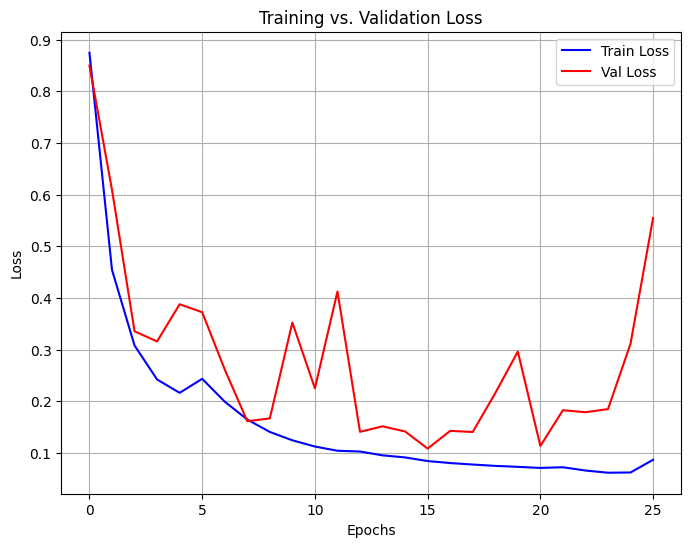

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
def plot_loss(history):
    plt.figure(figsize=(8, 6))

    # Plot training & validation loss
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Val Loss', color='red')

    # Labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.show()

# Call the function after training
plot_loss(history)


In [ ]:
y_pred = model.predict(x_test)  # Predict masks for test images


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [ ]:
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)  # Convert probability map to binary mask


In [ ]:
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)
print("y_pred_thresholded shape:", y_pred_thresholded.shape)


x_test shape: (7, 256, 256, 3)
y_test shape: (7, 256, 256, 1)
y_pred shape: (7, 256, 256, 1)
y_pred_thresholded shape: (7, 256, 256, 1)


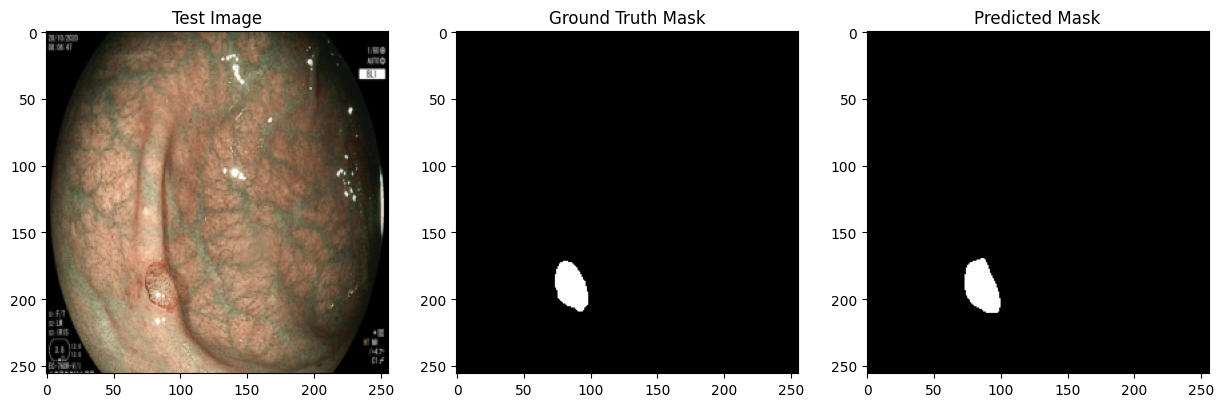

In [ ]:
import matplotlib.pyplot as plt
import random

# Select a random test image
index = random.randint(0, len(x_test) - 1)

plt.figure(figsize=(15, 5))

# Original test image
plt.subplot(1, 3, 1)
plt.imshow(x_test[index])
plt.title("Test Image")

# Ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(y_test[index, :, :, 0], cmap='gray')
plt.title("Ground Truth Mask")

# Predicted mask (thresholded)
plt.subplot(1, 3, 3)
plt.imshow(y_pred_thresholded[index, :, :, 0], cmap='gray')
plt.title("Predicted Mask")

plt.show()


In [ ]:
# Lists to store scores
dice_scores = []
iou_scores = []

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice and IoU for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming `iou` is your IoU function

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")


Mean Dice Score: 0.9053
Mean IoU Score: 0.8293


In [ ]:
import tensorflow as tf
import numpy as np

# Lists to store scores
dice_scores = []
iou_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming iou is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Compute F1 and F2 scores
if mean_precision + mean_recall > 0:
    f1_score = 2 * (mean_precision * mean_recall) / (mean_precision + mean_recall)
    f2_score = 5 * (mean_precision * mean_recall) / (4 * mean_precision + mean_recall)
else:
    f1_score, f2_score = 0.0, 0.0  # Avoid division by zero

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")


print(f"F1 Score: {f1_score:.4f}")
print(f"F2 Score: {f2_score:.4f}")


Mean Dice Score: 0.9053
Mean IoU Score: 0.8293
Mean Precision: 0.8946
Mean Recall: 0.9305
F1 Score: 0.9122
F2 Score: 0.9231


In [ ]:
import tensorflow as tf

# Lists to store scores
dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []

# Initialize the Keras Precision and Recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

# Loop through each test sample
for i in range(len(y_test)):
    # Convert to float32 before calculation
    y_true = y_test[i].astype(np.float32)
    y_pred = y_pred_thresholded[i].astype(np.float32)

    # Calculate Dice, IoU, Precision, and Recall for each sample
    dice = dice_coef(y_true, y_pred)
    iou_score = iou(y_true, y_pred)  # Assuming `iou` is your IoU function

    # Update the Precision and Recall metrics
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Append scores
    dice_scores.append(dice)
    iou_scores.append(iou_score)

# Final Precision and Recall after iterating through all test samples
mean_precision = precision_metric.result().numpy()
mean_recall = recall_metric.result().numpy()

# Calculate mean scores
mean_dice = np.mean(dice_scores)
mean_iou = np.mean(iou_scores)

# Print results
print(f"Mean Dice Score: {mean_dice:.4f}")
print(f"Mean IoU Score: {mean_iou:.4f}")
print(f"Mean Precision: {mean_precision:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")


Mean Dice Score: 0.9053
Mean IoU Score: 0.8293
Mean Precision: 0.8946
Mean Recall: 0.9305


In [ ]:
model.save('/content/drive/My Drive/BLIeff.h5')  # Saves model to Drive


In [ ]:
model.save('/content/drive/My Drive/BLIeff.keras')  # Saves model to Drive
